In [0]:
#!tar -xzvf lfw-funneled.tgz /content/AJ_Lamas/AJ_Lamas_0001.jpg
!unzip /content/LFW_Dataset_Subset.zip

In [0]:
!unzip /content/Attendance.zip

# Importing Libraries

In [0]:
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from PIL import Image 
from sklearn.preprocessing import OneHotEncoder
import cv2
import torch
import torch.nn as nn
from torch import optim
#from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm
import math
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import string
from google.colab import files
from sklearn.utils import shuffle
import os
import pandas as pd
import imageio
from pickle import dump
from joblib import dump, load
np.random.seed(0)

# Functions Definitions

In [0]:
# FFNN
def run_FFNN(X_train_scaled,X_test_scaled,Y_train,Y_test,class_name="FFNNetwork_Regularized",Epochs=6000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch'):
  if(class_name == "FFNNetwork_Regularized"):
    fn = FFNNetwork_Regularized()
  elif(class_name == "FFNNetwork"):
    fn = FFNNetwork()
  loss_fn = nn.CrossEntropyLoss() #fn.cross_entropy
  opt = optim.SGD(fn.parameters(), lr=0.9)  # optim.Adam(fn.parameters())
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  X_train_scaled = X_train_scaled.to(device)
  Y_train = Y_train.to(device)
  fn.to(device)

  tic = time.time()
  best_model = fit(X_train_scaled, Y_train.long(), fn, opt, loss_fn, epochs=Epochs,save_fig = save_fig)
  toc = time.time()
  fn.load_state_dict(best_model)
  print("Time for training model: {}s".format(np.round(toc-tic,3)))

  X_test_scaled =X_test_scaled.to(device)
  Y_test=Y_test.to(device)
  
  for k in [1,5]:
    accuracy_train = fn.accuracy_n(fn.forward(X_train_scaled),Y_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))


    accuracy_test = fn.accuracy_n(fn.forward(X_test_scaled),Y_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
    
  cm = confusion_matrix(Y_test.to("cpu").numpy(), torch.argmax(fn.forward(X_test_scaled), dim=1).to("cpu").to("cpu").detach().numpy())
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'_Confusion_matrix.png')
  else:
    plt.show()    

#  if(save_model == True):
#    torch.save(fn.to("cpu").state_dict(), model_save_dir )
#    torch.save(fn.state_dict(), save_dir) # saving the model

  return fn.forward(X_test_scaled), accuracy_test, fn

def fit(x, y, model, opt, loss_fn, epochs = 1000,save_fig = True, save_dir='Output-images/', save_name='FFNN_with_PyTorch_loss'):
  min_loss = 1000
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    x, y = shuffle(x, y, random_state=0)
    y_hat = model.forward(x)
    loss = loss_fn(y_hat, y)
    loss_arr.append(loss.item())
    acc_arr.append(model.accuracy(y_hat,y))
    loss.backward()
    opt.step()
    opt.zero_grad()
    if(loss.item() < min_loss):
      min_loss = loss.item()
      best_model = copy.deepcopy(model.state_dict())

  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy Loss")
  if(save_fig):
    plt.savefig(save_dir+save_name+'_loss.png')
  else:
    plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

  return best_model
  
def get_cropped_faces(cascade, eye_cascade, test_file_names,num_faces, form, path,  max_faces_per_person = 21, noise_level = 0.1, crop_dims=[28,116,20,108], w=128, h=128, scaleFactor = 1.1, minNeighbors=1, sF = 1.05, mN = 1):
  Y_train = np.array([])
  Y_val = np.array([])
  redundency_per_image = max_faces_per_person//2
  val_images = np.zeros(h*w)
  train_images = np.zeros(h*w)

  for i in tqdm(range(test_file_names.size)):
    modified_redundency_per_image = int(redundency_per_image - (num_faces[i]-1))//2
    if(modified_redundency_per_image > 0):
      ctr = modified_redundency_per_image
    _arr = np.random.randint(num_faces[i],size = 1)
    for j in range(num_faces[i]):
      val_idx = np.random.randint(modified_redundency_per_image, size=1)
      im = np.array(Image.open(path+"/{}/{}_{}".format(test_file_names[i],test_file_names[i],f"{j+1:04}"+form)))
      faces_rect = cascade.detectMultiScale(im, scaleFactor=scaleFactor, minNeighbors=minNeighbors)    
      for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
        crop_im = im[y:y+_h, x:x+_w]
        crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
        crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
        crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
        crop_im = hist_equalizer(crop_im)
        crop_im = get_aligned_img(crop_im,sF,mN)
        temp = np.array(crop_im)        
        train_images = np.row_stack((train_images,cv2.equalizeHist(temp).ravel()))
        Y_train = np.append(Y_train,i)
        if(ctr > 0):
          ctr -= 1
          for q in range(2):
            for k in range(modified_redundency_per_image):
              train_images = np.row_stack((train_images, generate_distorted_image(temp,h,w,q,noise_level).ravel() ))  
              Y_train = np.append(Y_train,i) 
        if(ctr == val_idx):
          for q in range(2):
            val_images = np.row_stack((val_images, generate_distorted_image(temp,h,w,q,noise_level).ravel() ))
            Y_val = np.append(Y_val,i)

  train_images = train_images[1:]
  val_images = val_images[1:]
  
  return train_images, val_images, Y_train, Y_val

def accuracy(yhat,Y_test):
  ctr = 0.0
  for i in range(Y_test.size):  
    if(yhat[i] == Y_test[i]):
      ctr += 1.0

  return ((ctr/Y_test.size)*100)
  
def generate_distorted_image(temp,h,w,j,noise_level=0.1):
  gray_new_img = cv2.equalizeHist(temp)  
  gray_new_img = Image.fromarray(gray_new_img)
  gray_new_img = np.array(gray_new_img.rotate(np.random.randn()*((-1)**j)*5))

  for l in range(gray_new_img.shape[0]):
    if(gray_new_img[l][0] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][ctr],0)):
        ctr += 1
      gray_new_img[l][0:ctr] = np.ones(gray_new_img[l][0:ctr].size)*gray_new_img[l][ctr]
    if(gray_new_img[l][-1] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[l][-1-ctr],0)):
        ctr += 1
      gray_new_img[l][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[l][gray_new_img.shape[1]-ctr:].size)*gray_new_img[l][-1-ctr]  
  
  gray_new_img = Image.fromarray((gray_new_img*(1+noise_level*((-1)**j)*np.random.randn(w,h))).astype(np.uint8) )  
  #gray_new_img = gray_new_img.crop((np.random.randint(10), np.random.randint(10), h-np.random.randint(10), w-np.random.randint(10))) 
  gray_new_img = gray_new_img.resize((w,h))
  gray_new_img = cv2.equalizeHist(np.array(gray_new_img).astype(np.uint8))
  return gray_new_img

def quadrant_checker(y):
  if(y<64 and y>0):
    return True
  else:
    return False
    
def get_aligned_img(img, sF=1.05, mN=1): # input PIL Image
  img = np.array(img)
  img_raw = img.copy() 
  eyes = eye_cascade.detectMultiScale(img,sF,mN)
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  eye_1 = (0,0,0,0)
  eye_2 = (0,0,0,0)
  eyes = np.array(eyes)
  possible_eyes = []
  for i in range(len(eyes)):
    if(quadrant_checker(eyes[i][1])):
      possible_eyes.append(i)
  eyes = eyes[possible_eyes]
  if(len(eyes) == 0):
    return cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)

  left_eye = eyes[np.argmin(eyes.T[0])]
  right_eye = eyes[np.argmax(eyes.T[0])]
  cv2.rectangle(img,(left_eye[0], left_eye[1]),(left_eye[0]+left_eye[2], left_eye[1]+left_eye[3]), 1)
  cv2.rectangle(img,(right_eye[0], right_eye[1]),(right_eye[0]+right_eye[2], right_eye[1]+right_eye[3]), 1)
  left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
  left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]

  right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
  right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]

  if(len(left_eye) == 0 or len(right_eye) == 0):
    return cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)

  cv2.circle(img, left_eye_center, 1, (255, 0, 0) , 1)
  cv2.circle(img, right_eye_center, 1, (255, 0, 0) , 1)
  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  if(left_eye_y > right_eye_y):
    point_3rd = (right_eye_x, left_eye_y)
    direction = -1 #rotate same direction to clock

  else:
    point_3rd = (left_eye_x, right_eye_y)
    direction = 1 #rotate inverse direction of clock

  cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
  cv2.line(img,left_eye_center, point_3rd,(67,67,67),1)
  cv2.line(img,right_eye_center, point_3rd,(67,67,67),1)
  
  a = euclidean_distance(left_eye_center, point_3rd)
  b = euclidean_distance(right_eye_center, left_eye_center)
  c = euclidean_distance(right_eye_center, point_3rd)

  if(b == 0 or c == 0):
    #new_img = Image.fromarray(img_raw)
    gray_new_img = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    #return gray_new_img

  else:
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = np.arccos(cos_a)
    angle = (angle * 180) / math.pi

    if direction == -1:
      angle = 90 - angle  

    new_img = Image.fromarray(img_raw)
    new_img = np.array(new_img.rotate(direction * angle))
    gray_new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

    for i in range(gray_new_img.shape[0]):
      if(gray_new_img[i][0] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][ctr],0)):
          ctr += 1
        gray_new_img[i][0:ctr] = np.ones(gray_new_img[i][0:ctr].size)*gray_new_img[i][ctr]
      if(gray_new_img[i][-1] == 0):
        ctr = 0
        while(np.allclose(gray_new_img[i][-1-ctr],0)):
          ctr += 1
        gray_new_img[i][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[i][gray_new_img.shape[1]-ctr:].size)*gray_new_img[i][-1-ctr]

  return gray_new_img

def euclidean_distance(a, b):
  x1 = a[0]; y1 = a[1]
  x2 = b[0]; y2 = b[1]
  return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

def detect_faces(cascade, test_image, scaleFactor = 1.1, minNeighbors= 1):
  # create a copy of the image to prevent any changes to the original one.
  image_copy = test_image.copy()
  
  #convert the test image to gray scale as opencv face detector expects gray images
  gray_image = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
  
  # Applying the haar classifier to detect faces
  faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
  
  for (x, y, w, h) in faces_rect:
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
      
  return image_copy, faces_rect

def cropper(im, w, h):
  width, height = im.shape[0], im.shape[1]
  
  left = (width - w)//2
  top = (height - h)//2
  right = (width + w)//2
  bottom = (height + h)//2

  return im[top:bottom, left:right]
  
"""It helps visualising the portraits from the dataset."""
def plot_portraits(images, h, w, n_row, n_col,save_fig=False,save_dir='Output-images/',save_name='Eigen_faces'):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    if(save_fig):
      plt.savefig(save_dir+save_name+'.png')

def pca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = np.linalg.svd(centered_data)
    components = V[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    print(U[:,:n_pc].shape, S[:n_pc].shape, V[:n_pc].shape)
    print(U.shape, S.shape, V.shape)
    return projected, components, mean, centered_data

def pca_PyTorch(X, n_pc): # ensure that X is in device
    n_samples, n_features = X.shape
    mean = torch.mean(X, axis=0)
    centered_data = X-mean
    U, S, V = torch.svd(centered_data)
    components = V.T[:n_pc]
    projected = U[:,:n_pc]*S[:n_pc]
    return projected, components, mean, centered_data

def reconstruction(Y, C, M, h, w, image_index):
    n_samples, n_features = Y.shape
    weights = np.dot(Y, C.T)
    centered_vector=np.dot(weights[image_index, :], C)
    recovered_image=(M+centered_vector).reshape(h, w)
    return recovered_image


def hist_equalizer(im):
  img_yuv = cv2.cvtColor(np.array(im), cv2.COLOR_BGR2YUV)
  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  # convert the YUV image back to RGB format
  im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
  return im

def get_k_acc_PyTorch(K,x_train,y_OH_train,x_test,y_OH_test):
  for k in K:
    accuracy_train = fn.accuracy_n(fn.forward(x_train),y_OH_train, topk=(k,))[0].item()
    print('Training Accuracy (top-{}): {}'.format(k,accuracy_train))

    x_test =x_test.to(device)
    y_OH_test=y_OH_test.to(device)

    accuracy_test = fn.accuracy_n(fn.forward(X_test),Y_OH_test, topk=(k,))[0].item()
    print('Testing Accuracy (top-{}): {}'.format(k,accuracy_test))
    print('\n')
#def reconstruction_PyTorch(Y, C, M, h, w, image_index):
#    n_samples, n_features = Y.shape
#    weights = torch.mm(Y, C.T)
#    centered_vector=torch.mm(weights[image_index, :], C)
#    recovered_image=(M+centered_vector).reshape(h, w)
#    return recovered_image

def accuracy_n(y_hat, y,topk=(1,)):
  maxk = max(topk)
  batch_size = y.size(0)

  _, pred = y_hat.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(y.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))

  return res


# kNN    
def euclideanDistance(x,y):
  distance = 0
  for i in range(x.size):
    distance += (x[i] - y[i])**2
  return np.sqrt(distance)

def first_comes_first(arr,x):
    arr[1:] = arr[0:-1]
    arr[0] = x
    return arr

def kNN(test_data,train_data,train_class,k):
  test_pred = np.zeros(test_data.shape[0])
  for i in range(test_data.shape[0]):
    dist_arr = np.asarray(np.zeros(k))
    nearest = np.asarray(np.zeros(k))
    ret_arr = np.array([])
    for j in range(k):
      dist_arr[j] = euclideanDistance(train_data[j],test_data[i])
      nearest[j]=j

    for j in range(train_data.shape[0]):
      temp_dist = euclideanDistance(test_data[i],train_data[j])
      if(temp_dist <= np.amin(dist_arr)):
        dist_arr = first_comes_first(dist_arr,temp_dist)
        nearest = first_comes_first(nearest,j)

    for j in (nearest):
      ret_arr = np.append(ret_arr,train_class[int(j)])
    ret_arr = np.array([int(q) for q in ret_arr])
    test_pred[i] = np.argmax(np.bincount(ret_arr))

  return test_pred

def getAccuracy(testSet, predictions):
  correct = 0
  testSet = np.array(testSet)
  for x in range(testSet.shape[0]):
    if (testSet[x] == predictions[x]):
      correct += 1
  return (correct/float(testSet.shape[0])) * 100.0

def run_kNN(X_train,X_test,Y_train,Y_test,k=[1,2,3,4,5],save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_kNN'):

  acc_arr = np.zeros(len(k))
  Y_pred = np.array([])
  max_acc = 0
  for i in range(len(k)):
    if(k[i] == 0):
      continue
    else:
      test_pred = kNN(X_test, X_train, Y_train, k[i])
      acc_arr[i] = (getAccuracy(test_pred, Y_test))
      print(k[i], acc_arr[i])
  acc_arr = np.array(acc_arr)
  Y_pred = kNN(X_test, X_train, Y_train, k[np.argmax(acc_arr)])
  print("Maximum accuracy obtained for k={} : {}".format(k[np.argmax(acc_arr)],np.amax(acc_arr)))

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
    plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()

  return Y_pred, np.amax(acc_arr)  
# SVM
def run_SVM(X_train_scaled,X_test_scaled,Y_train,Y_test, print_details = False,cv = 5,save_fig = False, save_dir='Output-images/',save_name='Confusion_matrix_SVM',grid_search=True,kernel=None,gamma=None,C=None):
  if(grid_search):
    params_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 0.005, 1e-4],
                        'C': [1, 10, 100, 500, 600,  725, 750, 775, 800, 900, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 50, 100, 200, 500, 750, 1000]}]
  else:
    params_grid = [{'kernel': [kernel], 'gamma': [gamma],
                        'C': [C]}]
  svm_model = GridSearchCV(SVC(), params_grid, cv=cv)
  svm_model.fit(X_train_scaled, Y_train)
  final_model = svm_model.best_estimator_
  Y_pred = final_model.predict(X_test_scaled)
  
  print("Training set score for SVM: %f" % final_model.score(X_train_scaled , Y_train))
  print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , Y_test ))

  if(print_details):
    print('Best score for training data:', svm_model.best_score_,"\n") 

    # View the best parameters for the model found using grid search
    print('Best C:',svm_model.best_estimator_.C,"\n") 
    print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
    print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
    print(confusion_matrix(Y_test,Y_pred))
    print("\n")
    print(classification_report(Y_test,Y_pred))
    svm_model.score

  cm = confusion_matrix(Y_test, Y_pred)
  #print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  #ax.set_xticklabels([''] + labels)
  #ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if(save_fig):
   plt.savefig(save_dir+save_name+'.png')
  else:
    plt.show()
  return Y_pred, final_model.score(X_test_scaled  , Y_test )*100, final_model

# Loading Enlarged Dataset

In [0]:
path = "/content"
folder = '/new'
a = np.array([])
with open(path+folder+"/new.txt",'r') as f:
  for line in f:
    if(len(line) != 0):
      if(a.size == 0):
        a = np.array(line.split())
      else:
        a = np.row_stack((a,line.split()))

names = []
n_faces = []
names = a.T[0]
n_faces = a.T[1]
del a
n_faces = n_faces.astype(np.uint8)
eye_cascade = cv2.CascadeClassifier(path+folder+'/haarcascade_eye.xml')
haar_cascade_face = cv2.CascadeClassifier(path+folder+'/haarcascade_frontalface_alt.xml')
n_persons = names.shape[0]
form = ".jpg"
w = 64
h = 64

In [0]:
train_images, val_images, Y_train, Y_val = get_cropped_faces(haar_cascade_face,eye_cascade,w=w,h=h,test_file_names=names,num_faces=n_faces, form=form,path=path+folder, crop_dims=[14,62,8,54],scaleFactor=1.01, minNeighbors=1,sF=1.05,mN=1) # 28,116,16,108

## Checking

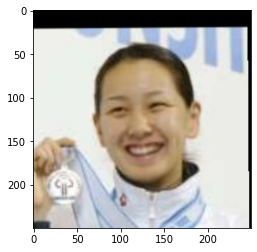

In [0]:
form = '.jpg'
im = np.array(Image.open(path+folder+'/'+names[72]+'/'+names[72]+'_0001'+form))
plt.imshow(im)

In [0]:
faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.01, minNeighbors=1)

In [0]:
faces_rect

array([[ 65,  66, 115, 115],
       [ 15, 183,  43,  43]], dtype=int32)

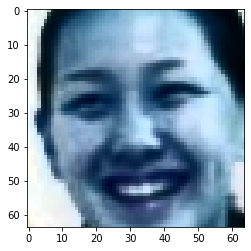

In [0]:
temp0 = np.array([])
w = 64#128
h = 64#128
for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
  crop_im = im[y:y+_h, x:x+_w]
  crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  #crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
  #crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
  crop_im = hist_equalizer(crop_im)
  #crop_im = cv2.cvtColor(crop_im, cv2.COLOR_RGB2GRAY)
  temp0 = np.array(crop_im)

plt.imshow(temp0)

In [0]:
sF = 1.05
mN = 1
img = np.array(temp0)
img_raw = img.copy() 
eyes = eye_cascade.detectMultiScale(img,sF,mN)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
eye_1 = (0,0,0,0)
eye_2 = (0,0,0,0)
eyes = np.array(eyes)
print(eyes)

[[31 13 21 21]
 [ 8 16 22 22]]


In [0]:
possible_eyes = []
for i in range(len(eyes)):
  if(quadrant_checker(eyes[i][1])):
    possible_eyes.append(i)

print(possible_eyes)

[0, 1]


In [0]:
eyes = eyes[possible_eyes]
print(eyes)

[[31 13 21 21]
 [ 8 16 22 22]]


In [0]:
left_eye = eyes[np.argmin(eyes.T[0])]
right_eye = eyes[np.argmax(eyes.T[0])]
print(left_eye, right_eye)

[ 8 16 22 22] [31 13 21 21]


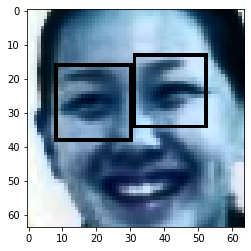

In [0]:
cv2.rectangle(img,(left_eye[0], left_eye[1]),(left_eye[0]+left_eye[2], left_eye[1]+left_eye[3]), 1)
cv2.rectangle(img,(right_eye[0], right_eye[1]),(right_eye[0]+right_eye[2], right_eye[1]+right_eye[3]), 1)

plt.imshow(img)


In [0]:
left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]

right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]

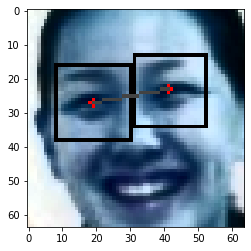

In [0]:
cv2.circle(img, left_eye_center, 1, (255, 0, 0) , 1)
cv2.circle(img, right_eye_center, 1, (255, 0, 0) , 1)
cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
plt.imshow(img)

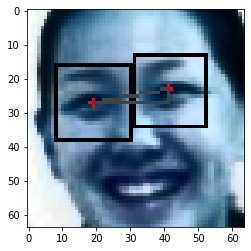

In [0]:
if(left_eye_y > right_eye_y):
  point_3rd = (right_eye_x, left_eye_y)
  direction = -1 #rotate same direction to clock

else:
  point_3rd = (left_eye_x, right_eye_y)
  direction = 1 #rotate inverse direction of clock

cv2.line(img,right_eye_center, left_eye_center,(67,67,67),1)
cv2.line(img,left_eye_center, point_3rd,(67,67,67),1)
cv2.line(img,right_eye_center, point_3rd,(67,67,67),1)
plt.imshow(img)

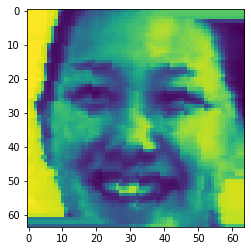

In [0]:
a = euclidean_distance(left_eye_center, point_3rd)
b = euclidean_distance(right_eye_center, left_eye_center)
c = euclidean_distance(right_eye_center, point_3rd)

if(b == 0 or c == 0):
  #new_img = Image.fromarray(img_raw)
  gray_new_img = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
  #return gray_new_img

else:
  cos_a = (b*b + c*c - a*a)/(2*b*c)
  angle = np.arccos(cos_a)
  angle = (angle * 180) / math.pi

  if direction == -1:
    angle = 90 - angle  

  new_img = Image.fromarray(img_raw)
  new_img = np.array(new_img.rotate(direction * angle))
  gray_new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

  for i in range(gray_new_img.shape[0]):
    if(gray_new_img[i][0] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[i][ctr],0)):
        ctr += 1
      gray_new_img[i][0:ctr] = np.ones(gray_new_img[i][0:ctr].size)*gray_new_img[i][ctr]
    if(gray_new_img[i][-1] == 0):
      ctr = 0
      while(np.allclose(gray_new_img[i][-1-ctr],0)):
        ctr += 1
      gray_new_img[i][gray_new_img.shape[1]-ctr:] = np.ones(gray_new_img[i][gray_new_img.shape[1]-ctr:].size)*gray_new_img[i][-1-ctr]

plt.imshow(gray_new_img)

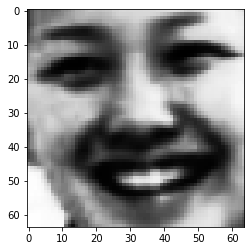

In [0]:
temp_img = hist_equalizer(cv2.resize(temp0[14:70,8:54], (w,h), interpolation = cv2.INTER_AREA))
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
plt.imshow(temp_img , cmap=plt.cm.gray)

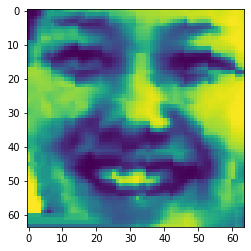

In [0]:
plt.imshow(cv2.equalizeHist(cv2.resize(gray_new_img[14:70,8:54], (w,h), interpolation = cv2.INTER_AREA)))

(1008, 16384)
(912,)
CPU times: user 48 s, sys: 746 ms, total: 48.7 s
Wall time: 48 s


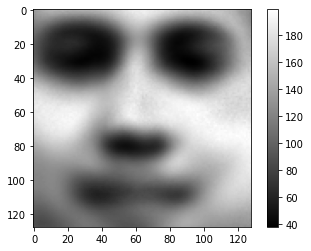

In [0]:
'''%%time 

noise_level = 0.1
h = 128 #min(min_dim_x,min_dim_y)
w = 128 #min(min_dim_x,min_dim_y)
redundency_per_image = 10
#if(redundency_per_image != 0):
#  val_idx = np.random.randint(redundency_per_image, size=len(labels))
#val_images = np.zeros(h*w)
train_images = np.zeros(h*w)

for i in range(len(labels)): # 
  im = Image.open(path+"{}.tga".format(labels[i]))
  #im = get_aligned_img(im)
  im = np.array(im) 
#  im = cv2.equalizeHist(im)
#  im = hist_equalizer(im)
#  im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) 
  temp = cv2.resize(im, (w,h), interpolation = cv2.INTER_AREA) 
  temp = get_aligned_img(temp)
  train_images = np.row_stack((train_images,cv2.equalizeHist(temp).ravel()))
  for j in range(2):
    for k in range(redundency_per_image):
      #if(k == val_idx[i]):
       # val_images = np.row_stack((val_images, generate_distorted_image(temp,h,w,j).ravel() ))
      #else:
      train_images = np.row_stack((train_images, generate_distorted_image(temp,h,w,j).ravel() ))
  
train_images = train_images[1:]
#val_images = val_images[1:]
print(train_images.shape)
#print(val_images.shape)
copies_per_image = 1+redundency_per_image*2
num_faces_per_person = 2*copies_per_image
Y_train = np.array([])
Y_val = np.array([])
if(redundency_per_image != 0):
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person))*(i+1))
#    Y_val = np.append(Y_val, np.ones(2*2)*(i+1))
else:
  for i in range(n_persons):
    Y_train = np.append(Y_train, np.ones((num_faces_per_person))*(i+1))
print(Y_train.shape)
#print(Y_val.shape)
mean_face = np.mean(train_images,axis=0)
plt.imshow(mean_face.reshape((h, w)), cmap=plt.cm.gray)
plt.colorbar()
plt.savefig('Output-images/mean_face.png')'''

# PCA

In [0]:
n_components = train_images.shape[0]//8 # next 18

In [0]:
X_train, C, M, Y = pca(train_images, n_pc=n_components) # C -> (12,1444) X_train -> (48,12) M -> (1,1444) Y -> (48,1444)
eigenfaces = C.reshape((n_components, h, w)) # eigenfaces -> (50, 64, 64)

(2101, 262) (262,) (262, 4096)
(2101, 2101) (2101,) (4096, 4096)


In [0]:
if(Y_val.size != 0):
  X_val = np.matmul(val_images-M,C.T) 

In [0]:
np.save('M_LFW.npy',M)
np.save('C_LFW.npy',C)

### Plotting

Eigen Faces (Number of components = 262)


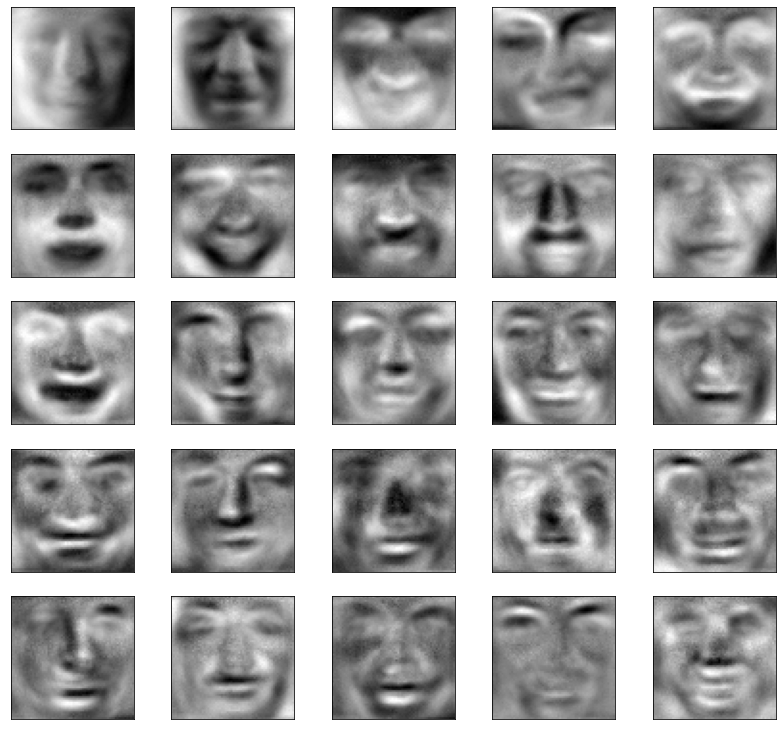

In [0]:
print("Eigen Faces (Number of components = {})".format(n_components))
plot_portraits(eigenfaces[:25], h, w, 5, 5,save_fig=True,save_dir='Output-images/',save_name='Eigen_faces_54')

### Reconstructing training set images

In [0]:
re_train_images=np.array([reconstruction(Y, C, M, h, w, i) for i in range(X_train.shape[0])])
plot_portraits(re_train_images[:160][::20], h, w, 2, 4,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Training_samples')

### Reconstructing validation set images

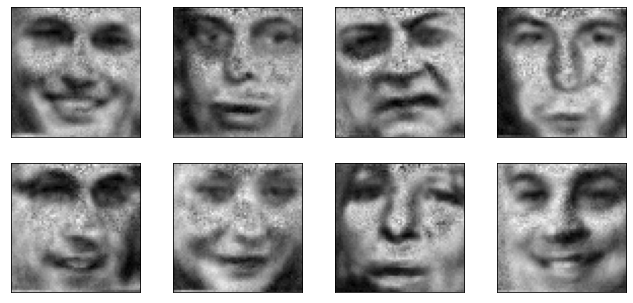

In [0]:
re_val_images = np.array([reconstruction(val_images-M, C, M, h, w, i) for i in range(X_val.shape[0])])
plot_portraits(re_val_images[:16][::2], h, w, 2, 4,save_fig=True,save_dir='Output-images/',save_name='Reconstructed_Validation_samples')

# Normalization

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)

# k-NN Based Classification

1 98.34710743801654
Maximum accuracy obtained for k=1 : 98.34710743801654
CPU times: user 3min 30s, sys: 5.26 s, total: 3min 35s
Wall time: 3min 24s


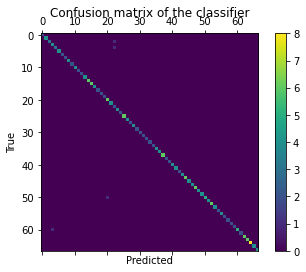

In [0]:
%%time
Y_pred_kNN, accuracy_kNN = run_kNN(X_train,X_val,Y_train,Y_val,save_fig=True,k=[1])
#Y_pred_kNN, accuracy_kNN = run_kNN(X_train.to("cpu").detach().numpy(),X_test.to("cpu").detach().numpy(),Y_OH_train.to("cpu").detach().numpy(),Y_OH_test.to("cpu").detach().numpy(),k=[1])

# Support Vector Machine Based Classification

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.958678
Best score for training data: 0.9071948874561702 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.001 

[[2 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 8 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 3]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         4
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         4
           6       0.80      1.00      0.89         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         4
          13       1.00      0.50      0.67         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 20.2 s, sys: 0 ns, total: 20.2 s
Wall time: 20.2 s


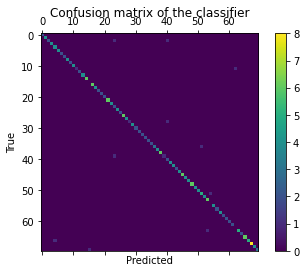

In [0]:
%%time
Y_pred_SVM, accuracy_SVM, svm_model = run_SVM(X_train_scaled,X_val_scaled,Y_train,Y_val,print_details=True,save_fig=True,grid_search=False, kernel='rbf',C=10,gamma=0.001)

# Porting to PyTorch

In [0]:
X_train_scaled, Y_train, X_val_scaled, Y_val = map(torch.tensor, (X_train_scaled, Y_train, X_val_scaled, Y_val))
#X_train_scaled, Y_OH_train, Y_train, X_test_scaled, Y_OH_test, Y_test = map(torch.tensor, (X_train_scaled, Y_OH_train, Y_train, X_test_scaled, Y_OH_test, Y_test))
X_train_scaled = X_train_scaled.float()
Y_train = Y_train.long()

X_val_scaled = X_val_scaled.float()
Y_val = Y_val.long()
#X_test_scaled = X_test_scaled.float()
#Y_test = Y_test.long()

# Training Neural Network on GPU

In [0]:
# simply define a silu function
def hakuna_matata(x,x0 = 0,a=1):
  return 2/(1+torch.exp(-a*(x-x0))) - 1 # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class Hakuna_Matata(nn.Module):
  def __init__(self,x0=0,a=1):
    super().__init__() # init the base class
    self.a = a
    self.x0 = x0

  def forward(self, ip):
    return hakuna_matata(ip,self.x0,self.a) # simply apply already implemented SiLU

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss before training 4.532536029815674
Loss after training 4.483325481414795
Time for training model: 136.007s
Training Accuracy (top-1): 100.0
Testing Accuracy (top-1): 92.24137878417969


Training Accuracy (top-5): 100.0
Testing Accuracy (top-5): 95.68965148925781




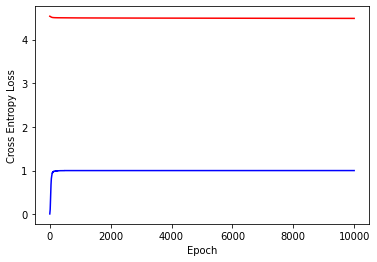

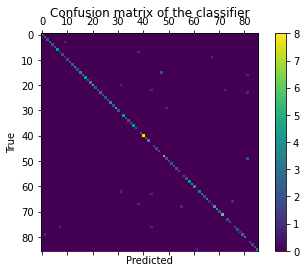

In [0]:
class RegularizedLinear(nn.Linear):
    def __init__(self, *args, ar_weight=1e-3, l1_weight=1e-3, l2_weight=2, **kwargs):
        super(RegularizedLinear, self).__init__(*args, **kwargs)
        #self.ar_weight = ar_weight
        #self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self._losses = {}

    def forward(self, input):
        output = super(RegularizedLinear, self).forward(input)
        #self._losses['activity_regularization'] = (output * output).sum() * self.ar_weight
        #self._losses['l1_weight_regularization'] = torch.abs(self.weight).sum() * self.l1_weight
        self._losses['l2_weight_regularization'] = torch.abs(torch.mul(self.weight,self.weight)).sum() * self.l2_weight
        return output

class FFNNetwork_Regularized(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.scale_factor = 0.75
    self.shift_param = +1.75
    self.net = nn.Sequential(
        #nn.Dropout(0.2),
        RegularizedLinear(n_components,2048), 
        nn.BatchNorm1d(2048),
        nn.Dropout(0.1),
        Hakuna_Matata(self.shift_param,self.scale_factor),
        #nn.Tanh(),
        #RegularizedLinear(4096,2048), 
        #nn.BatchNorm1d(2048),
        #Hakuna_Matata(self.shift_param,self.scale_factor),
        RegularizedLinear(2048,1024), 
        nn.BatchNorm1d(1024),
        Hakuna_Matata(self.shift_param,self.scale_factor),
        RegularizedLinear(1024,512), 
        nn.BatchNorm1d(512),
#        nn.Dropout(0.2),
        Hakuna_Matata(self.shift_param,self.scale_factor),
        #nn.Tanh(),
        RegularizedLinear(512, 250), 
        nn.BatchNorm1d(250),
        #nn.Dropout(0.04),
        Hakuna_Matata(self.shift_param,self.scale_factor),
        #nn.Tanh(),   
#        RegularizedLinear(250, 512), 
#        nn.BatchNorm1d(512),
#        nn.Tanh(),
#        nn.Dropout(0.1),
        #Hakuna_Matata(-1,1),
#        RegularizedLinear(512,512),
#        nn.BatchNorm1d(512),
#        nn.Tanh(),
#        RegularizedLinear(512,512),
#        nn.BatchNorm1d(512),
#        nn.Tanh(),
        RegularizedLinear(250,names.size),
        nn.BatchNorm1d(names.size),
#        nn.Dropout(0.1),
        Hakuna_Matata(self.shift_param,self.scale_factor),
        #nn.Tanh(),   
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

  def softmax(self,x):
    return torch.exp(x)/torch.sum(torch.exp(x))

  def cross_entropy(self,pred,label):
    yl=torch.mul(pred,label)
    yl=yl[yl!=0]
    yl=-torch.log(yl)
    yl=torch.mean(yl)
    return yl

  def accuracy(self,y_hat, y):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

  def predict(self, X):
    Y_pred = self.forward(X)
    return np.array(Y_pred).squeeze()
  
  def accuracy_n(self,y_hat, y,topk=(1,)):
    maxk = max(topk)
    batch_size = y.size(0)

    _, pred = y_hat.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
  
    return res

Y_pred_FFNN, accuracy_FFNN, model = run_FFNN(X_train_scaled,X_val_scaled,Y_train,Y_val,Epochs=10000,save_fig=True)

## Save Trained Model

In [0]:
torch.save(model.state_dict(),"/content/CLASS_FFNNetwork_LFW_92.txt")

## Load Trained Model

In [0]:
model = FFNNetwork_Regularized()
model.load_state_dict(torch.load("/content/CLASS_FFNNetwork_LFW_92.txt",  map_location=lambda storage, loc: storage)) 
model.eval()

FFNNetwork_Regularized(
  (net): Sequential(
    (0): RegularizedLinear(in_features=262, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Hakuna_Matata()
    (4): RegularizedLinear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Hakuna_Matata()
    (7): RegularizedLinear(in_features=1024, out_features=512, bias=True)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Hakuna_Matata()
    (10): RegularizedLinear(in_features=512, out_features=250, bias=True)
    (11): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Hakuna_Matata()
    (13): RegularizedLinear(in_features=250, out_features=93, bias=True)
    (14): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# ENSEMBLE CLASSIFIER

Vote weighted according to individual classifier accuracy score on test data

In [0]:
# As the FFNN outputs are torch tensors and on GPU, need to convert to numpy array and port to CPU
Y_pred_FFNN = Y_pred_FFNN.to("cpu").detach().numpy()
Y_pred_FFNN = np.argmax(Y_pred_FFNN,axis=1)

In [0]:
'''
weightage = [np.tanh(accuracy_kNN/100.0),np.tanh(accuracy_SVM/100.0),np.tanh(accuracy_FFNN/100.0)]
weightage /= sum(weightage)
print(weightage)
weightage = [np.exp(accuracy_kNN/100.0),np.exp(accuracy_SVM/100.0),np.exp(accuracy_FFNN/100.0)]
weightage /= sum(weightage)
print(weightage)
weightage = [1/np.log(accuracy_kNN/100.0),1/np.log(accuracy_SVM/100.0),1/np.log(accuracy_FFNN/100.0)]
weightage /= sum(weightage)
print(weightage)
weightage = [(accuracy_kNN),(accuracy_SVM),(accuracy_FFNN)]
weightage /= sum(weightage)
print(weightage)
'''

'\nweightage = [np.tanh(accuracy_kNN/100.0),np.tanh(accuracy_SVM/100.0),np.tanh(accuracy_FFNN/100.0)]\nweightage /= sum(weightage)\nprint(weightage)\nweightage = [np.exp(accuracy_kNN/100.0),np.exp(accuracy_SVM/100.0),np.exp(accuracy_FFNN/100.0)]\nweightage /= sum(weightage)\nprint(weightage)\nweightage = [1/np.log(accuracy_kNN/100.0),1/np.log(accuracy_SVM/100.0),1/np.log(accuracy_FFNN/100.0)]\nweightage /= sum(weightage)\nprint(weightage)\nweightage = [(accuracy_kNN),(accuracy_SVM),(accuracy_FFNN)]\nweightage /= sum(weightage)\nprint(weightage)\n'

In [0]:
enc = OneHotEncoder()
Y_OH_kNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_kNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_kNN.size]
Y_OH_SVM = enc.fit_transform(np.expand_dims(np.append(Y_pred_SVM,np.arange(n_persons)),1)).toarray()[0:Y_pred_SVM.size]
Y_OH_FFNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_FFNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_FFNN.size]
save_fig = True
save_dir = "Output-images/"
save_name = "Confusion_matrix_ensemble"

In [0]:
weightage = [1/np.log(accuracy_kNN/100.0),1/np.log(accuracy_SVM/100.0),1/np.log(accuracy_FFNN/100.0)]
weightage /= sum(weightage)
temp_Y_pred_ensemble = weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN 
Y_pred_ensemble = np.argmax(weightage[0]*Y_OH_kNN + weightage[1]*Y_OH_SVM + weightage[2]*Y_OH_FFNN , axis=1)

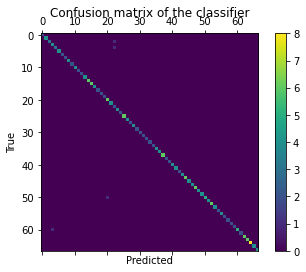

In [0]:
cm = confusion_matrix(Y_val, Y_pred_ensemble)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
if(save_fig):
  plt.savefig(save_dir+save_name+"_(kNN_SVM_FFNN).png")
else:
  plt.show()


In [0]:
for k in [1,5,10]:
    accuracy_val = accuracy_n(torch.tensor(temp_Y_pred_ensemble),Y_val, topk=(k,))[0].item()
    print('Validation Set Accuracy (top-{}): {}'.format(k,accuracy_val))


Validation Set Accuracy (top-1): 98.34710693359375
Validation Set Accuracy (top-5): 98.76033020019531
Validation Set Accuracy (top-10): 98.76033020019531


# Saving Training data

In [0]:
np.save('X_train_scaled_LFW.txt', X_train_scaled)
np.save('Y_train_LFW.npy', Y_train)
np.save('X_train_LFW.npy', X_train)

# Testing

In [0]:
Y_test = np.array([])
X_test = np.array([])
crop_dims=[14,62,8,54]
sF = 1.05
mN = 1
test_images = np.array([])
for img in os.listdir("/content/Attendance"):
  Y_test = np.append(Y_test,np.where(names == img[:-9]))
  im = np.array(Image.open(path+'/Attendance'+'/'+img))
  faces_rect = haar_cascade_face.detectMultiScale(im, scaleFactor=1.1, minNeighbors=1)    
  for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
    crop_im = im[y:y+_h, x:x+_w]
    crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
    crop_im = crop_im[crop_dims[0]:crop_dims[1],crop_dims[2]:crop_dims[3]]
    crop_im = cv2.resize(crop_im, (w,h), interpolation = cv2.INTER_AREA)
    crop_im = hist_equalizer(crop_im)
    crop_im = get_aligned_img(crop_im,sF,mN)
    temp = np.array(crop_im)        
    temp = cv2.equalizeHist(temp).ravel()
    if(test_images.size == 0):
      test_images = temp
    else:
      test_images = np.row_stack((test_images,temp))
    temp = np.matmul((temp-M),C.T)
    if(X_test.size == 0):
      X_test = temp
    else:
      X_test = np.row_stack((X_test,temp)) 


1 93.54838709677419
Maximum accuracy obtained for k=1 : 93.54838709677419


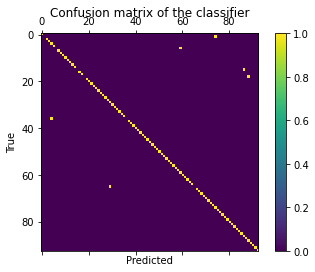

CPU times: user 1min 22s, sys: 2.57 s, total: 1min 25s
Wall time: 1min 20s


In [0]:
%%time
Y_pred_kNN, accuracy_kNN = run_kNN(X_train,X_test,Y_train,Y_test,save_fig=False,k=[1])

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.935484


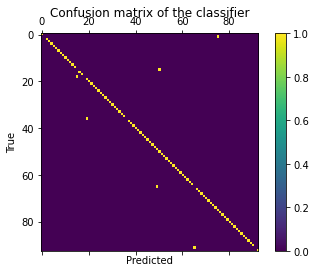

CPU times: user 20.4 s, sys: 27 ms, total: 20.4 s
Wall time: 20.4 s


In [0]:
%%time
_X_train = np.loadtxt("/content/X_train.txt")
_X_train_scaled = np.loadtxt("/content/X_train_scaled.txt")
_Y_train = np.loadtxt("/content/Y_train.txt")
X_test_scaled = scaler.transform(X_test)
Y_pred_SVM, accuracy_SVM, svm_model = run_SVM(_X_train_scaled,X_test_scaled,_Y_train,Y_test,print_details=False,save_fig=False,grid_search=False, kernel='rbf',C=10,gamma=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


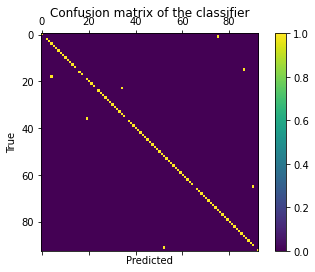

92.47311827956989


In [0]:
FFNN_model = FFNNetwork_Regularized()
FFNN_model.load_state_dict(torch.load("/content/CLASS_FFNNetwork_LFW_92.txt",  map_location=lambda storage, loc: storage)) 
FFNN_model.eval()
X_test_scaled = torch.tensor(X_test_scaled).float()
with torch.no_grad():
  pred = FFNN_model.predict(X_test_scaled)

Y_pred_FFNN = np.argmax(pred,axis=1)

cm = confusion_matrix(Y_test, Y_pred_FFNN)
#print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(accuracy(Y_pred_FFNN,Y_test))

# Attendance

In [0]:
def label_test_images(cascade,scaleFactor,minNeighbors,dir_list,pred,names,data_dir,save_dir):
  for i in range(np.array(dir_list).size):
    im = np.array(Image.open(data_dir+'/'+dir_list[i]))
    faces_rect = cascade.detectMultiScale(im, scaleFactor=scaleFactor, minNeighbors=minNeighbors)    
    name = names[pred[i]]
    for (x, y, _w, _h) in [faces_rect[np.argmax(faces_rect.T[-1])]]:
      cv2.rectangle(im, (x, y), (x+_w, y+_h), (0, 255, 0), 2)
      cv2.putText(im, name, (x + 6, y+_h - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
      imageio.imwrite(save_dir+'/'+dir_list[i], im)

def update_attendance(pred,names,save_dir,date):
  data = np.unique(pred)
  enc = OneHotEncoder()
  data = np.sum(enc.fit_transform(np.expand_dims(np.append(data,np.arange(n_persons)),1)).toarray()[0:data.size],axis=0)
  #date=str(sys.argv[1]) #'25.05.2020'
  if(os.path.exists(save_dir+'/Attendance.xlsx')):
    df = pd.read_excel(save_dir+'/Attendance.xlsx', sheet_name='Students')
  else:
    df = pd.DataFrame(names,columns=['Name'])

  df[date] = data  
  df.to_excel(save_dir+"/Attendance.xlsx", sheet_name='Students',index=False)  


In [0]:
_weightage = np.array([0.3,0.3,0.4])
enc = OneHotEncoder()
_Y_OH_kNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_kNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_kNN.size]
_Y_OH_SVM = enc.fit_transform(np.expand_dims(np.append(Y_pred_SVM,np.arange(n_persons)),1)).toarray()[0:Y_pred_SVM.size]
_Y_OH_FFNN = enc.fit_transform(np.expand_dims(np.append(Y_pred_FFNN,np.arange(n_persons)),1)).toarray()[0:Y_pred_FFNN.size]
_Y_pred_ensemble = np.argmax(_weightage[0]*_Y_OH_kNN + _weightage[1]*_Y_OH_SVM + _weightage[2]*_Y_OH_FFNN , axis=1)

In [0]:
folder = "/Attendance"
save_folder = "/Labelled_images"
dir_list = os.listdir(path+folder) 
label_test_images(haar_cascade_face,1.1,1,dir_list,_Y_pred_ensemble,names,path+folder,path+save_folder)
update_attendance(_Y_pred_ensemble,names,path+save_folder,date='25.05.2020')

In [0]:
_Y_train = np.loadtxt("Y_train.txt")

# Misc

In [0]:
data = np.unique(Y_pred_ensemble)
data = np.sum(enc.fit_transform(np.expand_dims(np.append(data,np.arange(n_persons)),1)).toarray()[0:data.size],axis=0)

In [0]:
date='25.05.2020'
if(os.path.exists(path+'/Attendance.xlsx')):
  df = pd.read_excel(path+'/Attendance.xlsx', sheet_name='Students')
else:
  df = pd.DataFrame(names,columns=['Name'])

df[date] = data  
df.to_excel("Attendance.xlsx", sheet_name='Students',index=False)  